In [1]:
import os
import sys
# sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '\\ultils')
# os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import prince
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *
from plots import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

# myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
# sns.set(style="whitegrid", font=myfont.get_name())
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

c:\Users\USER\Desktop\TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
]
# select_lst = dataA1.columns
def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

dist_dfA2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] != '未紀錄']
dist_dfA1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] != '未紀錄']
car_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '車的狀態']
car_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '車的狀態']

car_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
car_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

car_A2 = car_A2[car_A2['肇因研判大類別名稱-主要'] != '非駕駛者']
car_A1 = car_A1[car_A1['肇因研判大類別名稱-主要'] != '非駕駛者']
car_A2 = car_A2[car_A2['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)']
car_A1 = car_A1[car_A1['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)']
# 刪掉原因為類似於他提供不了更多資訊，但會使Mapper更加分散
car_A2 = car_A2[car_A2['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)']
car_A1 = car_A1[car_A1['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)']

car_A2 = car_A2[car_A2['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
car_A1 = car_A1[car_A1['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']

car_A2 = car_A2[car_A2['車輛撞擊部位大類別名稱-最初'] != '未紀錄']
car_A1 = car_A1[car_A1['車輛撞擊部位大類別名稱-最初'] != '未紀錄']


C:\Users\USER\AppData\Local\Temp\ipykernel_40716\3605155225.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_40716\3605155225.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)


篩選掉未紀錄資料以及分類人的狀態以及車的狀態

In [4]:
from sklearn.utils import resample

sampling_ratio = 0.33  # 下採樣比例

# 計算 A1 和 A2 原始數據量比例
A1_total = len(car_A1)
A2_total = len(car_A2)
total_ratio = A1_total / A2_total  # 保留 A1/A2 的比例

# 定義函數，按月份進行下採樣
def downsample_by_month_simple(A1, A2, sampling_ratio, total_ratio):
    A1_downsampled = pd.DataFrame()
    A2_downsampled = pd.DataFrame()

    months = sorted(set(A1['發生月份']).intersection(A2['發生月份']))  # 確保月份匹配

    for month in months:
        # 提取該月份的資料
        A1_month = A1[A1['發生月份'] == month]
        A2_month = A2[A2['發生月份'] == month]

        # 計算該月份目標數量
        A1_target = int(len(A1_month) * sampling_ratio)
        A2_target = int(A1_target / total_ratio)
        print(A1_target)
        print(A2_target)

        # 下採樣
        A1_sampled = resample(A1_month, replace=False, n_samples=A1_target, random_state=42)
        A2_sampled = resample(A2_month, replace=False, n_samples=A2_target, random_state=42)

        # 合併到最終結果
        A1_downsampled = pd.concat([A1_downsampled, A1_sampled])
        A2_downsampled = pd.concat([A2_downsampled, A2_sampled])

    return A1_downsampled.reset_index(drop=True), A2_downsampled.reset_index(drop=True)

# 下採樣
downsampled_A1, downsampled_A2 = downsample_by_month_simple(car_A1, car_A2, sampling_ratio, total_ratio)
# Concat
rbind_data = pd.concat([downsampled_A1, downsampled_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

44
10080
45
10309
40
9163
35
8018
36
8247
39
8934
47
10767
43
9851
40
9163
47
10767


In [5]:
bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (95715, 146)


# Kmode

In [269]:
from kmodes.kmodes import KModes

data_for_kmode = rbind_data.drop(['死亡', '受傷'], axis=1)


cost = []
all_results = {}
K = range(1, 10)

for k in K:
    
    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=5
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

Best run was number 1
Best run was number 4
Best run was number 8
Best run was number 2
Best run was number 9
Best run was number 9
Best run was number 3
Best run was number 4
Best run was number 7


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [275]:
pd.Series(all_results[3]['labels']).value_counts()
rbind_data['Cluster'] = all_results[3]['labels']

# MCA

In [ ]:
mca = prince.MCA(
    one_hot=False,
    n_components=7,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
    # random_state=43
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

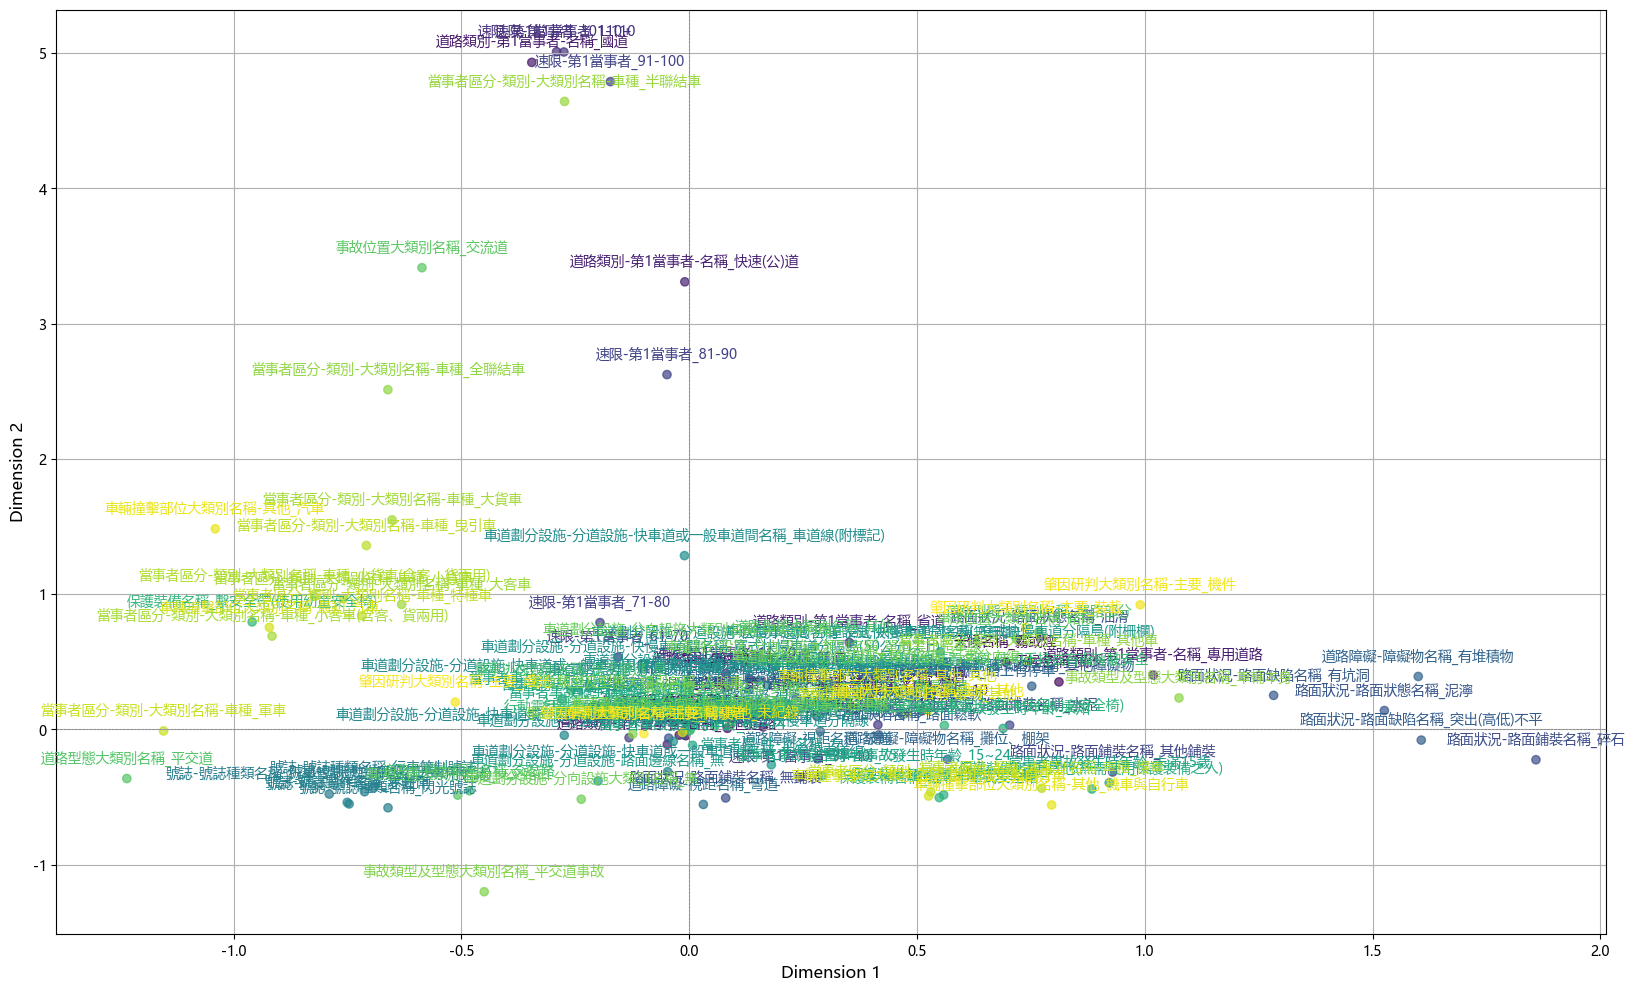

In [175]:
col_coordinate = mca.column_coordinates(data_to_map)

col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

# Normalize the 'dummy_index' for mapping to colormap
norm = plt.Normalize(vmin=col_coordinate['dummy_index'].min(), vmax=col_coordinate['dummy_index'].max())
cmap = cm.viridis  # 選擇漸層色盤，例如 viridis, plasma, inferno 等

plt.figure(figsize=(20, 12))
plt.gca().set_facecolor('white')

# 繪製散點圖，顏色根據 dummy_index 映射
scatter = plt.scatter(
    col_coordinate[0],  # X coordinate
    col_coordinate[1],  # Y coordinate
    c=col_coordinate['dummy_index'],  # 使用索引作為顏色映射
    cmap=cmap,
    alpha=0.7
)

# Adding labels with colors matching the scatter plot
offset = 0.15
for i, label in enumerate(col_coordinate.index):
    plt.text(
        col_coordinate.iloc[i, 0],  # X coordinate
        col_coordinate.iloc[i, 1] + offset,  # Y coordinate
        str(label),  # 假設 label 包含中文
        fontsize=10,
        ha='center', 
        va='center',
        color=cmap(norm(col_coordinate.iloc[i]['dummy_index'])),  # 文字顏色與點顏色一致
        # rotation=30
    )

# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label("Field Index (Gradient)", fontsize=12)

# Axes lines and grid
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# plt.title("MCA", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(True)

plt.show()

In [194]:
Overlap = [2.1]
Interval = [14]

In [195]:
detailed_results = []

for overlap in Overlap:
    silhouette_for_intervals = []

    for interval in Interval:
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=10
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component7Car/results_o{overlap}i{interval}.pkl"
            # filename = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o{overlap}i{interval}.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 2.1, interval: 14


Processing Clusters: 100%|██████████| 5512/5512 [00:04<00:00, 1216.57it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component7Car/results_o2.1i14.pkl


In [6]:
# detailed_results_df = pd.DataFrame(detailed_results)

# output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Component7Car/full_grid.pkl'
# with open(output_file, 'wb') as f:
#     pickle.dump(detailed_results_df, f)

# output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component8Car/full_grid.pkl'

# with open(output_file, 'rb') as f:
#     detailed_results_df = pickle.load(f)

with open('Version3/GridSearch/Component7Car/results_o2i14.pkl', 'rb') as f:
    detailed_results_df = pickle.load(f)

In [ ]:
rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']
rbind_data['顯著特徵'].unique()

# 目前分析使用的模型

Mapper plot created.
Data extracted.
Colors mapped using predefined mapping.


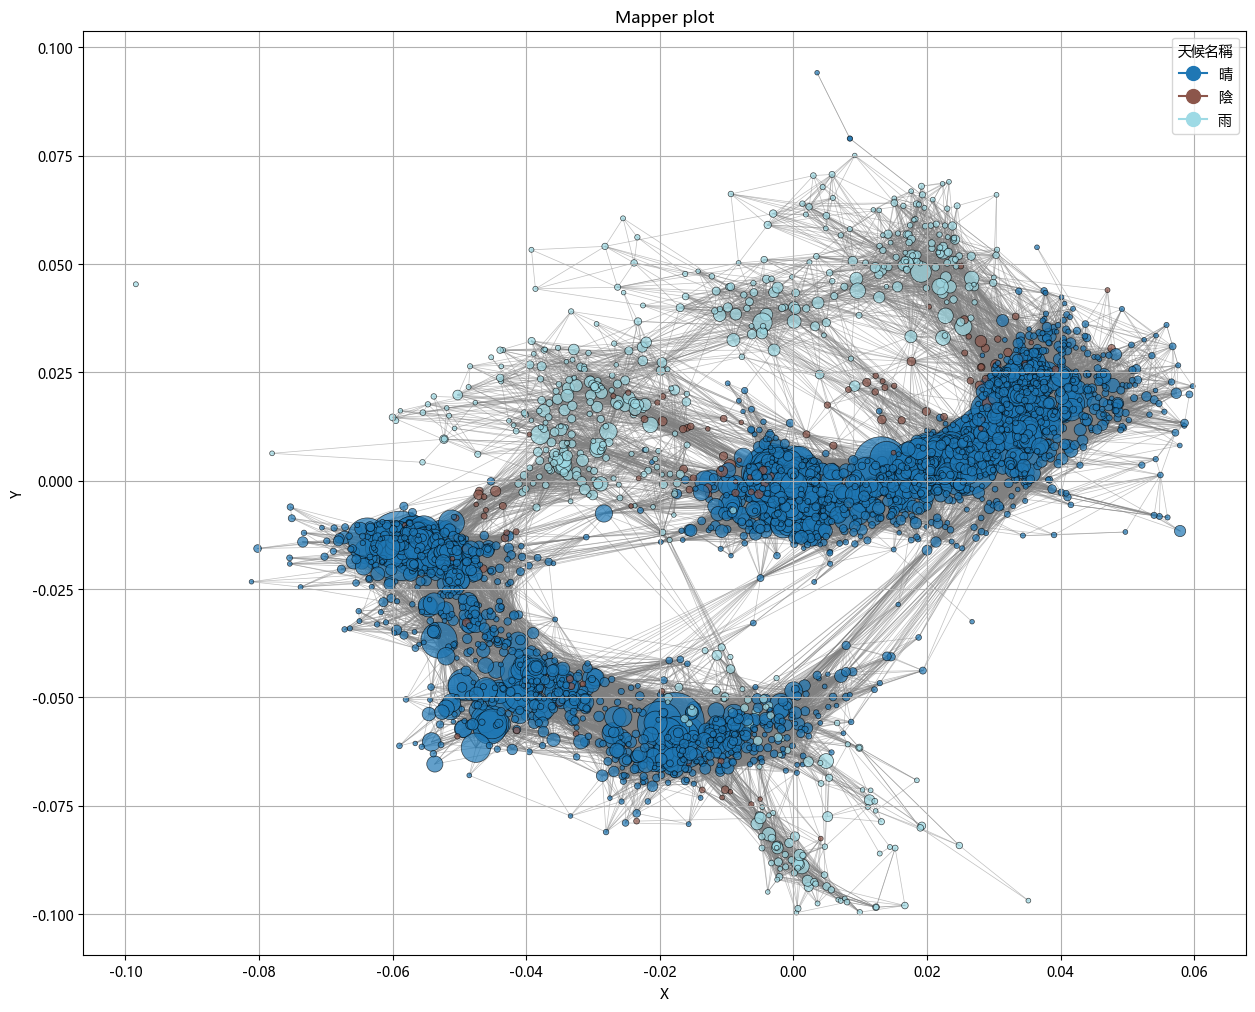

In [8]:
choose = '天候名稱'

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=10, iterations=100)
mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
full_info = mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, size=10, threshold=700)
mapper_plotter.plot(choose, avg=False, set_label=True, size=100000)

In [ ]:
for choose in lst_analyze:
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=10, iterations=100)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    full_info = mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=10, threshold=700)
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
            save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Car/o2_i14_filter_{choose}.png")

In [ ]:
# choose = 'Cluster'
choose = '死亡'

unique_categories = rbind_data[choose].dropna().unique()
unique_categories.sort()

color_palette = get_cmap("tab20", len(unique_categories))
color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[39][0], rbind_data, detailed_results_df)
mplot = mapper_plotter.create_mapper_plot(choose, average_encoded_label, avg=True)
mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, size=30, threshold=0) # 篩選資料
mapper_plotter.plot(choose, unique_categories, color_palette, avg=True, 
                    set_label=True, size=100000)

In [ ]:
choose = '事故位置大類別名稱'

for index in range(detailed_results_df.shape[0]):

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[index][0], rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=30, threshold=0)
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Car/o{detailed_results_df['overlap'].iloc[index]}_i{detailed_results_df['interval'].iloc[index]}.png")


# Polygon

In [ ]:
from shapely.geometry import Point, Polygon

rectangle1 = Polygon([(-0.1, 0.04), (-0.1, 0.1), (0.1, 0.1), (0.1, -0.032), (0, -0.032)])
rectangle2 = Polygon([(-0.1, -0.12), (-0.1, 0.04), (0, -0.032), (0.1, -0.032), (0.1,  -0.12)])


# filtered_full_info = full_info[(full_info['y'] > -0.3) & (full_info['y'] < 0.2) & (full_info['x'] > -0.25) & (full_info['x'] < 0.25)]
# filtered_full_info = filtered_full_info[filtered_full_info['size'] > 10]
filtered_full_info = full_info

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)

label_0 = filtered_full_info[inside_indices_1]
label_1 = filtered_full_info[inside_indices_2]

# 提取區域內和區域外的數據
all_inside_indices = inside_indices_1 | inside_indices_2
outside_indices = ~all_inside_indices

label_out = filtered_full_info[outside_indices]

# assert label_0.shape[0] + label_1.shape[0] + label_out.shape[0] == filtered_full_info.shape[0]

# 繪製數據點和矩形區塊
plt.figure(figsize=(10, 8))
plt.scatter(label_0['x'], label_0['y'], label='1', color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], label='2', color='blue', s=10)
plt.scatter(label_out['x'], label_out['y'], color='red', s=10)

# 繪製矩形區塊
for rect, color in zip([rectangle1, rectangle2], ['green', 'blue']):
    x, y = rect.exterior.xy
    plt.plot(x, y, color=color, linestyle='--')

# 圖形調整
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

In [332]:
# mapper_plotter.plot_graph(G, color_mapping)

In [10]:
def get_unique_ids(input_data):
    unique_ids = set()
    for ids_list in input_data['ids']:
        unique_ids.update(ids_list)
    return list(unique_ids)

# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_out = get_unique_ids(label_out)

full_0 = dummy_data.loc[count_0]
full_1 = dummy_data.loc[count_1]
full_out = dummy_data.loc[count_out]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_out.shape[0])
print(dummy_data.shape[0])

94304
95715


In [11]:
def get_train_test_data(input_data):
    input_data['y'] = input_data['死亡'].apply(lambda x: 1 if x >= 1 else 0)
    
    input_data.drop(columns=['受傷', '死亡'], inplace=True)
    
    X = input_data.drop(columns=['y'])
    y = input_data['y']

    return X, y

def get_metrics(input_data):

    metrics_log, accuracy_log, conf_matrix_log = logistic_cm_gridsearch(X, y)
    # metrics_rf, accuracy_rf, conf_matrix_rf, best_params_rf = random_forest_dummy_classifier(X, y)

    full_metrics = {
        'logistic': {
            'metrics': metrics_log,
            'accuracy': accuracy_log,
            'conf_matrix': conf_matrix_log,
        },
        # 'random_forest': {
        #     'metrics': metrics_rf,
        #     'accuracy': accuracy_rf,
        #     'conf_matrix': conf_matrix_rf,
        #     'best_params': best_params_rf
        # }
    }

    return full_metrics

In [ ]:
return_1 = get_metrics(full_0)
return_2 = get_metrics(full_1)
return_out = get_metrics(full_out)
dummy_data = pd.get_dummies(rbind_data)
origin = get_metrics(dummy_data)

In [20]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler

def logistic_cm_gridsearch(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

    print("Original train class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))

    smote = SMOTE(random_state=42, k_neighbors=3)
    enn = EditedNearestNeighbours(n_neighbors=3)
    smote_enn = SMOTEENN(smote=smote, enn=enn)
    X_resampled_train, y_resampled_train = smote_enn.fit_resample(X_train, y_train)

    print("Resampled train class distribution:", dict(zip(*np.unique(y_resampled_train, return_counts=True))))

    min_class_count = min(sum(y_test == 0), sum(y_test == 1))
    
    rus_test = RandomUnderSampler(sampling_strategy={0: min_class_count, 1: min_class_count}, random_state=42)
    X_resampled_test, y_resampled_test = rus_test.fit_resample(X_test, y_test)

    print("Resampled test class distribution:", dict(zip(*np.unique(y_resampled_test, return_counts=True))))

    model = LogisticRegression(solver='saga', max_iter=10000)
    
    parameters = {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100]
    }

    grid_search = GridSearchCV(model, parameters, cv=5, scoring='accuracy')
    grid_search.fit(X_resampled_train, y_resampled_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_resampled_test)

    conf_matrix = confusion_matrix(y_resampled_test, y_pred)
    accuracy = accuracy_score(y_resampled_test, y_pred)

    precision = precision_score(y_resampled_test, y_pred, average=None, zero_division=0)
    recall = recall_score(y_resampled_test, y_pred, average=None)
    f1 = f1_score(y_resampled_test, y_pred, average=None)

    metrics_df = pd.DataFrame({
        'Label': [f'Class_{i}' for i in range(len(precision))],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    return metrics_df, accuracy, conf_matrix

In [14]:
X0, y0 = get_train_test_data(full_0)
X1, y1 = get_train_test_data(full_1)
Xout, yout = get_train_test_data(full_out)

In [21]:
matrix_0, score_0, cm_0 = logistic_cm_gridsearch(X0, y0)

Original train class distribution: {0: 40962, 1: 165}
Resampled train class distribution: {0: 40962, 1: 40596}
Resampled test class distribution: {0: 67, 1: 67}


c:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.



In [337]:
print(y0.value_counts())
print(y1.value_counts())
print(yout.value_counts())

0    58521
1      232
Name: y, dtype: int64
0    32620
1      139
Name: y, dtype: int64
0    2767
1      25
Name: y, dtype: int64
